# Introduction

This project consists of a Rubiks cube scanner. It asumes that three sides is always visible to the camera and predicts the colors of the pieces on those sides. The pieces are outputed in "camera space", not "3D rubiks cube space", which means that the models does not take the orientation of the cube into consideration which would be necessary to get a full Rubiks cube model. It is however pretty easy to do as an extension, since the middle piece on each side is fixed they can be used to map what the camera sees to a full 3D model. I have actually done this in a seperate project with a high degree of success, but I choose not to include it here because it is not related to the course (deep learning) and its not yet perfect.

The training data is generated with a Rubiks cube simulator that I wrote with the javascript library [three.js](https://github.com/mrdoob/three.js) and it can be found [here](https://github.com/AntonPicetti/Rubiks-GUI/tree/Training-Set-Generator). For each camera/cube configuration that was generated in the simulator the cube was scrambled and a new camera position was choosen from the path seen in red in the image below. The path is choosen so that three sides is always visible to the camera. For each configuration in the simulation, datapoints are created for each dataset.

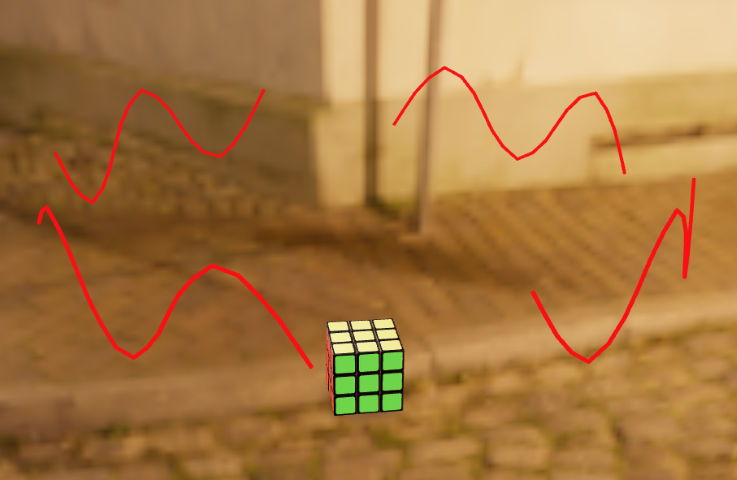

The pipeline consists of the following steps:
1. Image Segmentation with U-Net
	- Model: U-Net
	- Input: 128x128 image of cube captured by camera.
	- Output: a binary mask idicating if a pixel is a cube piece or not.
2. Split segmentation mask into subareas
	- Model: no deep learning model!
	- Input: the binary mask from the previous step.
	- Output: the same mask but with a unique class for each square instead of binary 0/1.
3. Color classifier
	- Model: CNN
	- Input: 32x32 image of a cube piece.
	- Output: a number (0-5) corresponding to the color of the piece.
4. Piece classifier
	- Model: CNN
	- Input: a binary mask with all pixels of one piece set to true.
	- Output: a number (0-26) corresponding to the piece that was set to true.

To get a better understanding of the pipeline, scroll to the last section "Models integration" and look at the output at the bottom to see the full pipeline in action!

## How to access datasets used in this notebook
The datasets are available in a zip file on [google drive](https://drive.google.com/file/d/163saL1aNUO1f2jIPBroYYMoG6DOmXyUd/view?usp=sharing). Here are the steps to use it.
- Download the zip file and extract it.
- Upload the extracted folder to Colab.
- Upadate the variable `rubiks_volume_path` below so it points to the folder.

# Result / Discussion

# Setup

In [39]:
# Set this to the path of the rubiks volume that was downloaded from google drive.
rubiks_volume_path = "/home/rubiks-volume"

## Load libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
from keras.models import Sequential 
from keras.layers import Dense, Flatten, InputLayer
from keras.metrics import BinaryAccuracy
import colorsys
from skimage.measure import label
import json
import uuid
import pandas as pd

## Utility functions and constants

In [2]:
def load_images(image_dir, include_file_order=False):
    # Lists to store loaded images.
    input_images = []

    # Ensure the directory exists and contains images.
    if not os.path.isdir(image_dir):
        raise ValueError("One of the directories does not exist.")

    file_order = []
    # Iterate through the filenames in the directory.
    for filename in os.listdir(image_dir):
        file_order.append(filename)

        # Construct the full path to the image file.
        image_path = os.path.join(image_dir, filename)

        # Load the image and convert it to a numpy array.
        with Image.open(image_path) as img:
            input_images.append(np.array(img))

    # Convert lists to numpy arrays.
    input_images = np.array(input_images)

    if include_file_order:
        return input_images, file_order
    else:
        return input_images

In [3]:
def load_in_and_out_images(input_dir, labels_dir, include_file_order=False):
    # Lists to store loaded images
    input_images = []
    label_images = []

    # Ensure the directory exists and contains images
    if not os.path.isdir(input_dir) or not os.path.isdir(labels_dir):
        raise ValueError("One of the directories does not exist.")

    file_order = []
    # Iterate through the filenames in the input directory
    for filename in os.listdir(input_dir):
      file_order.append(filename)
      # Construct the full path to the image file
      input_path = os.path.join(input_dir, filename)
      label_path = os.path.join(labels_dir, filename)

      # Check if the corresponding label image exists
      if os.path.exists(label_path):
          # Open, load the image and convert it to a numpy array
          with Image.open(input_path) as img:
              input_images.append(np.array(img))
          with Image.open(label_path) as img:
              label_images.append(np.array(img))
      else:
          print(f"Label for {filename} not found.")

    # Convert lists to numpy arrays
    input_images = np.array(input_images)
    label_images = np.array(label_images)

    if include_file_order:
      return input_images, label_images, file_order
    else:
      return input_images, label_images

In [4]:
color_names = [
    "green",
    "yellow",
    "blue",
    "white",
    "red",
    "orange"
]

## Plotting Functions

In [6]:
def plot_images(images, title=None, cm=None):
    plt.figure()
    plt.tight_layout()
    n = len(images)
    for i, image in enumerate(images):
      plt.subplot(int("1" + str(n) + str(i+1)))
      if cm:
        plt.imshow(image, cmap=cm)
      else:
        plt.imshow(image)

    if title:
      plt.suptitle(title)

In [7]:
def plot_images_grid(images, nrows, ncols, sub_titles=None, title=None):
    fig, axs = plt.subplots(nrows, ncols, figsize=(5, 5))

    # Iterate over the grid and populate it with images and subtitles
    for i, ax in enumerate(axs.flat):
        ax.axis("off")
        ax.imshow(images[i])

        # Set the subtitle for each subplot
        if isinstance(sub_titles, np.ndarray) or sub_titles:
            ax.set_title(sub_titles[i], fontsize=10)

    # Adjust layout to make room for the subtitle.
    plt.tight_layout(pad=3.0, h_pad=1.0, w_pad=1.0)

    # Set the title for the entire figure
    if title:
        fig.suptitle(title, fontsize=14)

    plt.show()

In [8]:
# Visualize each subarea of the segmentation mask with a unique color.
def generate_unique_colors(n):
    # Generate colors by varying the Hue, keeping Saturation and Lightness constant.
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.7
        lightness = 0.6
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        colors.append(rgb)

    return colors

def plot_labeled_mask(mask):
  unique_colors = generate_unique_colors(np.max(mask))
  unique_colors = [[0.5, 0.5, 0.5]] + unique_colors # add background color.
  unique_colors = np.array(unique_colors)

  img = unique_colors[mask]
  plot_images([img], title="Labeled mask")

In [9]:
def draw_point(image, y, x):
  k=1
  for row in range(y-k, y+k+1):
    for col in range(x-k, x+k+1):

      image[row][col] = np.array([1, 0, 1])

def draw_centers(image, centers):
  img_cpy = image+0.5

  for i, center in enumerate(centers):
    draw_point(img_cpy, center[0], center[1])

  plot_images([img_cpy], title="Centers")

In [56]:
def visualize_cube(piece_predictions, color_predictions):
    pixel_colors = [
        [0, 255, 00],
        [255, 255, 0],
        [0, 0, 255],
        [200, 200, 200],
        [255, 0, 0],
        [255, 165, 0]
    ]

    index_map = [0, 1, 2, 7, 8, 3, 6, 5, 4]

    piece_colors = {} # contains the predicted color for each piece.
    for i, piece in enumerate(piece_predictions):
        piece_colors[piece] = color_predictions[i]

    # (side, row, col, pixel)
    viz_sides = np.zeros((3, 3, 3, 3)).astype(np.uint8)

    for i in range(3):
        for j, idx in enumerate(index_map):
            color = piece_colors[idx + i*9]
            pixel = pixel_colors[color]
            viz_sides[i][j//3][j%3] = pixel


    plot_images_grid(viz_sides, 1, 3, sub_titles=["U", "F", "L"], title="Vizualization of the predicted cube")

## Preprocessing Functions

In [11]:
def normalize(image):
    return (image / 255.0) - 0.5

In [12]:
def reduce(image):
    return image[:, :, :, :1]

In [13]:
def substitute_values(image):
  image[image == 255] = 2

## Model Base Class
This is the base class that the all model classes will inherit from. Having a base class makes it possible to reuse frequently used methods.

In [24]:
# Base class for models.
class Model:
    def __init__(self, input_dir, output_dir):
        input_data, output_data = load_in_and_out_images(input_dir, output_dir)
        input_data, output_data = self.preprocess(input_data, output_data)
        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def preprocess(self, input_data, output_data):
        # preprocessing will be different for each model.
        pass

    def prepare_dataset(self, input_data, output_data):
        DataSplitRatios = (0.7, 0.2, 0.1)
        n = len(input_data)
        split1ix = int(n * DataSplitRatios[0])
        split2ix = int(n * (DataSplitRatios[0] + DataSplitRatios[1]))

        train_dataset = {
            "input": input_data[:split1ix],
            "output": output_data[:split1ix],
        }
        validation_dataset = {
            "input": input_data[split1ix:split2ix],
            "output": output_data[split1ix:split2ix],
        }
        test_dataset = {
            "input": input_data[split2ix:],
            "output": output_data[split2ix:],
        }

        assert (
            len(train_dataset["input"]) + len(validation_dataset["input"]) + len(test_dataset["input"])
            == n
        )

        return train_dataset, validation_dataset, test_dataset

    def build(self):
        # Model will be different for each model.
        pass

    def compile(self):
        pass

    def summary(self):
        self.model.summary()

    def train(self):
        pass

    def evaluate(self):
        test_loss, test_accuracy = self.model.evaluate(self.test_dataset["input"], self.test_dataset["output"])
        print(f"Test loss: {test_loss}")
        print(f"Test accuracy: {test_accuracy}")

    def pop_history(self):
        # Sometimes the inital loss is super high which makes it hard to see the rest of the graph.
        # This function pops the first element of the history arrays.
        # Use only if necessary.
        for key in self.model_history.history:
            self.model_history.history[key].pop(0)

    def plot_history(self):
        pd.DataFrame(self.model_history.history).plot(figsize=(8,5))

    def predict(self, input_data):
        return self.model.predict(input_data)

# Step 1 - Image Segmentation with U-Net
In this step of the pipeline the input image will be segmented into areas for each piece of the cube. To do this I will be using U-Net.

### Define U-Net Model
The implementation of U-Net is copied from [this notebook](https://colab.research.google.com/github/margaretmz/image-segmentation/blob/main/unet_pet_segmentation.ipynb#scrollTo=RoNAcRnMzlrC) and the corresponding [blog post](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/).

In [25]:
# U-NET model for image segmentation.
class SegmentationModel(Model):
    def __init__(self, input_dir, output_dir):
        super().__init__(input_dir, output_dir)

    def preprocess(self, input_data, output_data):
        input_data = normalize(input_data)

        output_data = reduce(
            output_data
        )  # Only one color channel is necessary for the mask.
        substitute_values(output_data)

        return input_data, output_data

    def build(self):
        def double_conv_block(x, n_filters):
            # Conv2D then ReLU activation
            x = layers.Conv2D(
                n_filters,
                3,
                padding="same",
                activation="relu",
                kernel_initializer="he_normal",
            )(x)
            # Conv2D then ReLU activation
            x = layers.Conv2D(
                n_filters,
                3,
                padding="same",
                activation="relu",
                kernel_initializer="he_normal",
            )(x)

            return x

        def downsample_block(x, n_filters):
            f = double_conv_block(x, n_filters)
            p = layers.MaxPool2D(2)(f)
            p = layers.Dropout(0.3)(p)

            return f, p

        def upsample_block(x, conv_features, n_filters):
            # upsample
            x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
            # concatenate
            x = layers.concatenate([x, conv_features])
            # dropout
            x = layers.Dropout(0.3)(x)
            # Conv2D twice with ReLU activation
            x = double_conv_block(x, n_filters)

            return x

        def build_unet_model():
            # inputs
            inputs = layers.Input(shape=(128, 128, 3))

            # encoder: contracting path - downsample
            # 1 - downsample
            f1, p1 = downsample_block(inputs, 64)
            # 2 - downsample
            f2, p2 = downsample_block(p1, 128)
            # 3 - downsample
            f3, p3 = downsample_block(p2, 256)
            # 4 - downsample
            f4, p4 = downsample_block(p3, 512)

            # 5 - bottleneck
            bottleneck = double_conv_block(p4, 1024)

            # decoder: expanding path - upsample
            # 6 - upsample
            u6 = upsample_block(bottleneck, f4, 512)
            # 7 - upsample
            u7 = upsample_block(u6, f3, 256)
            # 8 - upsample
            u8 = upsample_block(u7, f2, 128)
            # 9 - upsample
            u9 = upsample_block(u8, f1, 64)

            # outputs
            outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

            # unet model with Keras Functional API
            unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

            return unet_model

        self.model = build_unet_model()

    def compile(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="sparse_categorical_crossentropy",
            metrics="accuracy",
        )

    def train(self):
        self.model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            epochs=10,
            # shuffle=True,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return self.model_history

In [26]:
input_dir = f"{rubiks_volume_path}/data-ready-for-training/segmentation-input"
labels_dir = f"{rubiks_volume_path}/data-ready-for-training/segmentation-output"
segmentationModel = SegmentationModel(input_dir, labels_dir)

Plot a few input/output images:

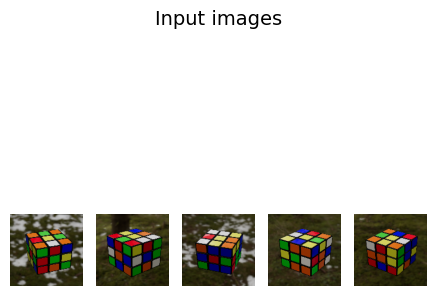

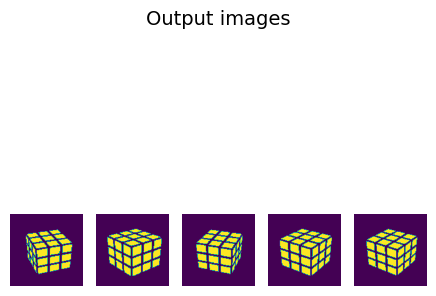

In [27]:
plot_images_grid(segmentationModel.train_dataset["input"][:5]+0.5, 1, 5, title="Input images")
plot_images_grid(segmentationModel.train_dataset["output"][:5], 1, 5, title="Output images")

### Build, compile and train U-Net

In [28]:
segmentationModel.build()
segmentationModel.compile()
segmentationModel.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_20[0][0]']           
 g2D)                                                                                         

In [29]:
segmentationModel.train()

Epoch 1/10
22/22 [==============================] - 8s 171ms/step - loss: 2.2019 - accuracy: 0.7331 - val_loss: 0.5300 - val_accuracy: 0.7964
Epoch 2/10
22/22 [==============================] - 3s 150ms/step - loss: 0.3743 - accuracy: 0.8254 - val_loss: 0.1986 - val_accuracy: 0.9170
Epoch 3/10
22/22 [==============================] - 3s 150ms/step - loss: 0.1547 - accuracy: 0.9299 - val_loss: 0.1185 - val_accuracy: 0.9423
Epoch 4/10
22/22 [==============================] - 3s 150ms/step - loss: 0.1060 - accuracy: 0.9512 - val_loss: 0.0787 - val_accuracy: 0.9668
Epoch 5/10
22/22 [==============================] - 3s 151ms/step - loss: 0.0706 - accuracy: 0.9703 - val_loss: 0.0512 - val_accuracy: 0.9790
Epoch 6/10
22/22 [==============================] - 3s 150ms/step - loss: 0.0555 - accuracy: 0.9775 - val_loss: 0.0440 - val_accuracy: 0.9830
Epoch 7/10
22/22 [==============================] - 3s 150ms/step - loss: 0.0477 - accuracy: 0.9818 - val_loss: 0.0386 - val_accuracy: 0.9859
Epoch 

### Evaluate U-Net

4/4 [==============================] - 0s 29ms/step - loss: 0.0291 - accuracy: 0.9888
Test loss: 0.02906242199242115
Test accuracy: 0.9888432621955872


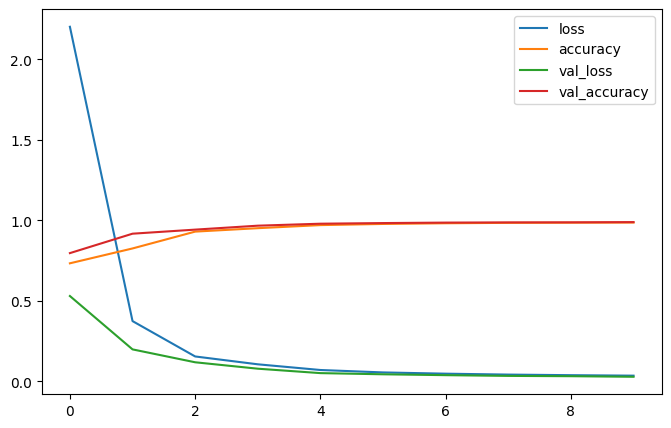

In [30]:
segmentationModel.evaluate()

#segmentationModel.pop_history() # Use only if necessary.
segmentationModel.plot_history()

4/4 [==============================] - 1s 120ms/step


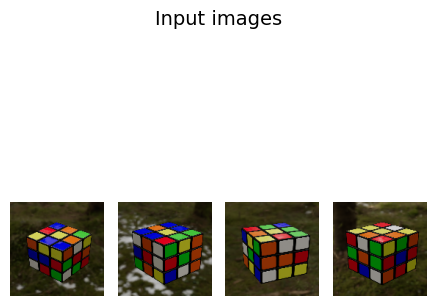

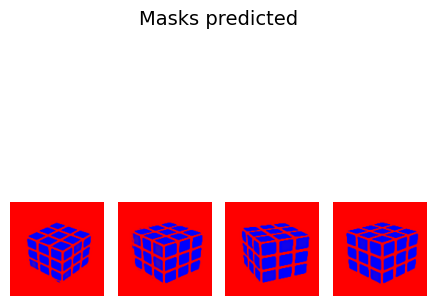

In [32]:
masks_predicted = segmentationModel.predict(segmentationModel.test_dataset["input"])

plot_images_grid(segmentationModel.test_dataset["input"][:4]+0.5, 1, 4, title="Input images")
plot_images_grid(masks_predicted[:4], 1, 4, title="Masks predicted")

In [141]:
# The model seems fine, save it to disk so that it can be used for preprocessing in the future.
segmentationModel.model.save(f"{rubiks_volume_path}/models/segmentation_model")

# Step 2 - Split segmentation mask into subareas

In [33]:
# Convert the masks to binary format.
def format_masks(masks):
  masks = np.copy(masks[:,:,:,0])
  masks[masks < 0.5] = 0
  masks[masks >= 0.5] = 1
  masks = ~masks.astype(bool)
  return masks

# Split masks into subareas.
def label_masks(formated_masks):
    labeled_masks = [label(mask, connectivity=2) for mask in formated_masks]
    labeled_masks = np.array(labeled_masks)
    return labeled_masks

### Analysis of threshold value

mean: 135.76018922852984
std: 61.3258856607454
min: 1
max: 343


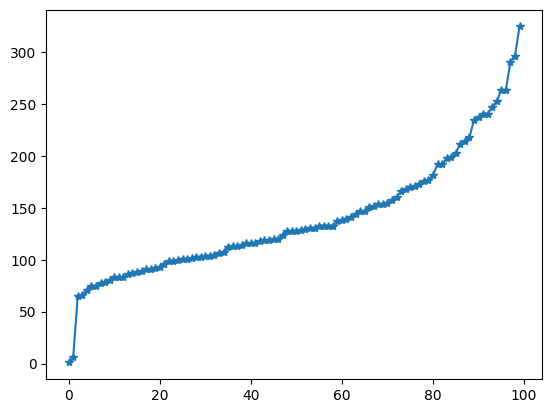

In [34]:
# Analyze the size of all areas to get an understanding of a reasonable
# threshold value for the apply_threshold function.
def get_area_sizes():
  all_areas_sizes = []
  for labeled_mask in label_masks(format_masks(masks_predicted)):
    _, unique_counts = np.unique(labeled_mask, return_counts=True)

    # Ignore the first class (background)
    all_areas_sizes += list(unique_counts[1:])

  return np.array(all_areas_sizes)

all_areas_sizes = get_area_sizes()

print(f"mean: {np.mean(all_areas_sizes)}")
print(f"std: {np.std(all_areas_sizes)}")
print(f"min: {np.min(all_areas_sizes)}")
print(f"max: {np.max(all_areas_sizes)}")
plt.plot(sorted(list(all_areas_sizes)[:100]), "-*")

In [35]:
# Apply a threshold function to filter out small areas (noise).
# Assign background class (0) to all pixels belonging to invalid classes.
# From the analysis above 16 seems like a reasonable threshold for a valid side.
def apply_threshold(labeled_masks, threshold=16):
  for idx in range(labeled_masks.shape[0]):
    label_classes, counts = np.unique(labeled_masks[idx], return_counts=True)
    invalid_classes = label_classes[counts < threshold]
    for invalid_class in invalid_classes:
      labeled_masks[idx][labeled_masks[idx] == invalid_class] = 0

### Process and visualize mask subareas

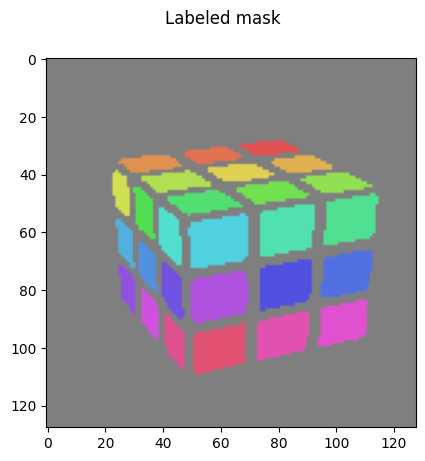

In [36]:
def post_process_masks(masks):
  masks = format_masks(masks)
  labeled_masks = label_masks(masks)
  apply_threshold(labeled_masks)
  return labeled_masks


masks = post_process_masks(masks_predicted)
idx = 2
plot_labeled_mask(masks[idx])

# Step 3 - Color classifier

In [42]:
class ColorClassifier(Model):
    def __init__(self, input_dir, output_file):
        input_data, file_order = load_images(input_dir, True)
        input_data = normalize(input_data)
        
        with open(output_file) as f:
            output_data = json.load(f)

        # Reorder output data to match input data.
        output_data = np.array([output_data[filename] for filename in file_order])

        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def build(self):
        # 32x32 image as input.
        # probability of each color as output.

        self.model = Sequential()

        # Add convolutional layers
        self.model.add(
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3))
        )
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))

        # Flattening the output of the convolutional layers to feed into the dense layer
        self.model.add(layers.Flatten())

        # Add dense layers
        self.model.add(layers.Dense(64, activation="relu"))
        self.model.add(
            layers.Dense(6, activation="softmax")
        )  # 6 classes for the output layer

    def compile(self):
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self):
        self.model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            shuffle=True,
            epochs=5,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return self.model_history

    def predict(self, input_data):
        predictions = self.model.predict(input_data)
        predictions = np.argmax(
            predictions, axis=1
        )  # convert one hot to class numbers.
        return predictions

In [43]:
input_data = f"{rubiks_volume_path}/data-ready-for-training/color-input"
output_data = f"{rubiks_volume_path}/data-ready-for-training/color-output.json"

colorClassifier = ColorClassifier(input_data, output_data)

colorClassifier.build()
colorClassifier.compile()

In [44]:
colorClassifier.train()

Epoch 1/5
498/498 [==============================] - 4s 6ms/step - loss: 0.1253 - accuracy: 0.9576 - val_loss: 5.3238e-04 - val_accuracy: 1.0000
Epoch 2/5
498/498 [==============================] - 3s 6ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 2.2372e-04 - val_accuracy: 1.0000
Epoch 3/5
498/498 [==============================] - 3s 6ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 2.2670e-04 - val_accuracy: 1.0000
Epoch 4/5
498/498 [==============================] - 3s 6ms/step - loss: 7.8361e-05 - accuracy: 1.0000 - val_loss: 7.8727e-06 - val_accuracy: 1.0000
Epoch 5/5
498/498 [==============================] - 3s 6ms/step - loss: 2.3927e-05 - accuracy: 1.0000 - val_loss: 6.5744e-06 - val_accuracy: 1.0000


72/72 [==============================] - 1s 9ms/step - loss: 3.9546e-05 - accuracy: 1.0000
Test loss: 3.954619023716077e-05
Test accuracy: 1.0


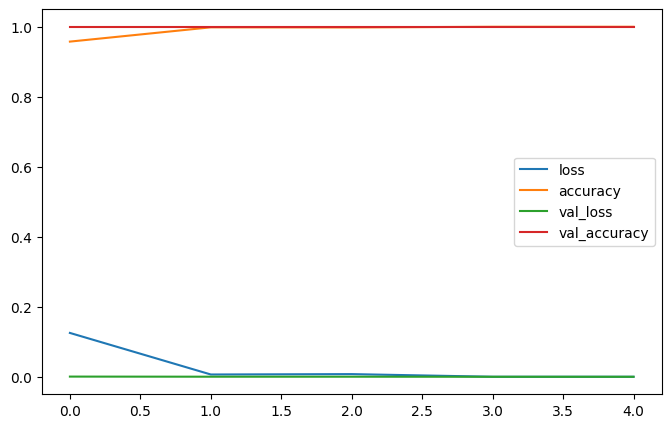

In [45]:
colorClassifier.evaluate()
colorClassifier.plot_history()

As mentioned in the discussion, the output above makes it very clear that the dataset genereated by the simulator currently is too easy. A test accuracy of 1.0 after 5 epochs of training is not realistic enough! I do think that other lighting conditions with a lot of reflections for example can make it harder for the model.

In [46]:
color_predictions = colorClassifier.predict(colorClassifier.test_dataset["input"])

72/72 [==============================] - 0s 3ms/step


Let's plot the input images along with the color class that the model predicted:

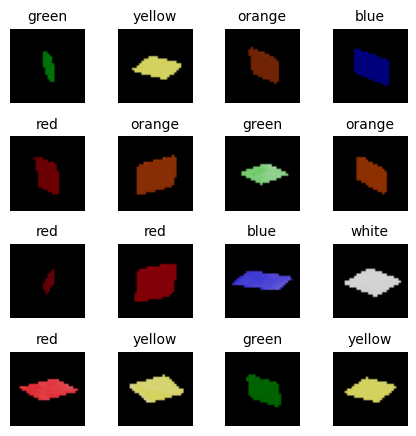

In [47]:
plot_images_grid(colorClassifier.test_dataset["input"][:16]+0.5, 4, 4, sub_titles=list(map(lambda x: color_names[x], color_predictions[:16])))

# Step 4 - Piece Classifier

In [48]:
class PieceClassifier(Model):
    def __init__(self, input_dir, output_file):
        input_data, file_order = load_images(input_dir, True)
        input_data = normalize(input_data)

        with open(output_file) as f:
            output_data = json.load(f)

        # Reorder output data to match input data.
        output_data = np.array([output_data[filename] for filename in file_order])

        self.train_dataset, self.validation_dataset, self.test_dataset = (
            self.prepare_dataset(input_data, output_data)
        )

    def build(self):
        self.model = Sequential()

        # Add convolutional layers
        self.model.add(
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1))
        )
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation="relu"))

        # Flattening the output of the convolutional layers to feed into the dense layer
        self.model.add(layers.Flatten())

        # Add dense layers
        self.model.add(layers.Dense(64, activation="relu"))
        self.model.add(
            layers.Dense(27, activation="softmax")
        )  # 27 classes for the output layer

        # Compile the model
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Model summary
        self.model.summary()

    def compile(self):
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )

    def train(self):
        self.model_history = self.model.fit(
            x=self.train_dataset["input"],
            y=self.train_dataset["output"],
            batch_size=32,
            epochs=10,
            shuffle=True,
            validation_data=(
                self.validation_dataset["input"],
                self.validation_dataset["output"],
            ),
        )

        return self.model_history

    def predict(self, input_data):
        predictions = self.model.predict(input_data)
        predictions = np.argmax(
            predictions, axis=1
        )  # convert one hot to class numbers.
        return predictions

In [49]:
input_data = f"{rubiks_volume_path}/data-ready-for-training/piece-input"
output_data = f"{rubiks_volume_path}/data-ready-for-training/piece-output.json"

pieceClassifier = PieceClassifier(input_data, output_data)

pieceClassifier.build()
pieceClassifier.compile()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 50176)            

In [50]:
pieceClassifier.train()

Epoch 1/10
24/24 [==============================] - 3s 38ms/step - loss: 1.9775 - accuracy: 0.5079 - val_loss: 0.4086 - val_accuracy: 0.8140
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.2932 - accuracy: 0.9127 - val_loss: 0.2458 - val_accuracy: 0.9023
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 0.2184 - accuracy: 0.9365 - val_loss: 0.1693 - val_accuracy: 0.9395
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.9722 - val_loss: 0.0516 - val_accuracy: 0.9860
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0247 - accuracy: 0.9921 - val_loss: 0.0256 - val_accuracy: 0.9953
Epoch 6/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0150 - val_accuracy: 0.9953
Epoch 7/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 8/10
24/24 [=

4/4 [==============================] - 0s 94ms/step - loss: 0.0040 - accuracy: 1.0000
Test loss: 0.004036018159240484
Test accuracy: 1.0


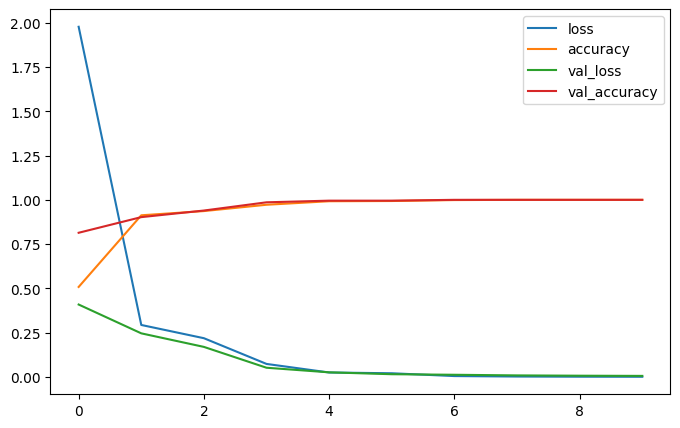

In [51]:
pieceClassifier.evaluate()
pieceClassifier.plot_history()

Here we see the same thing as we did with the color classifier, the dataset seems to be too easy!

In [52]:
piece_predictions = pieceClassifier.predict(pieceClassifier.test_dataset["input"])

4/4 [==============================] - 0s 52ms/step


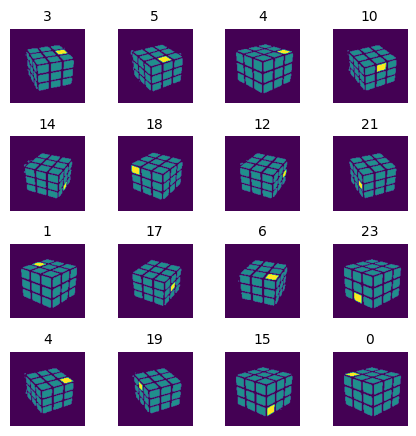

In [53]:
plot_images_grid(pieceClassifier.test_dataset["input"][:16]+0.5, 4, 4, sub_titles=piece_predictions[:16])

The numbers above each subplot is the class that the model predicted. The correct number for each piece can be found in the image below.

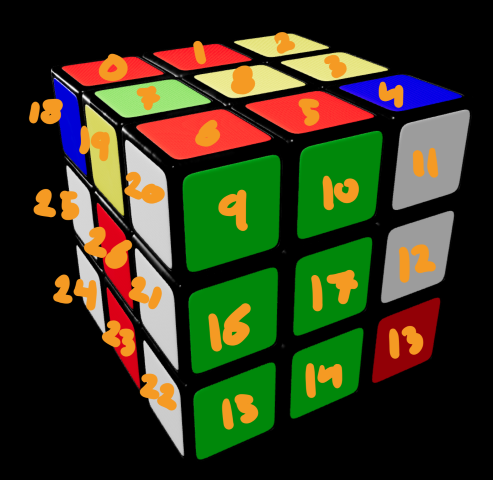

# Models integration
Let's combine the models into a full pipeline with an image of a cube as input and the color of each piece as output.

In [54]:
def create_masks(unet_model, input_data):
  # TODO: apply thereshold to the masks?
  masks_predicted = unet_model.predict(input_data)
  formated_masks = format_masks(masks_predicted)
  return formated_masks

def create_labeled_masks(unet_model, input_data):
  formated_masks = create_masks(unet_model, input_data)

  # Split masks into subareas.
  labeled_masks = np.squeeze(label_masks(formated_masks))

  apply_threshold(labeled_masks)

  return labeled_masks

def create_centers_set(labeled_masks):
  centers_set = []
  for mask in labeled_masks:
    unique, indices = np.unique(mask, return_index=True)

    # Get the indices where each unique value occurs in 'mask'. Then calculate
    # the mean of the indices for each unique value
    true_indices = [np.where(mask == value) for value in unique[1:]]
    means = np.array([[np.mean(indices[0]), np.mean(indices[1])] for indices in true_indices])
    centers = np.around(means).astype(np.uint8)
    centers_set.append(centers)

  return centers_set

# Temporary solution! Removes all datapoints that doesn't have 27 centers.
def remove_bad_datapoints(centers_set, other_sets):
  print(f"Number of datapoints before removal: {len(centers_set)}")

  bad_indicies = []
  for i, datapoint in enumerate(centers_set):
    if len(datapoint) != 27:
      bad_indicies.append(i)

  # Remove bad datapoints.
  centers_set = np.array([datapoint for i, datapoint in enumerate(centers_set) if i not in bad_indicies])
  filtered_datasets = []
  for dataset in other_sets:
    filtered_datasets.append(np.array([datapoint for i, datapoint in enumerate(dataset) if i not in bad_indicies]))
  
  print(f"Number of datapoints after removal: {len(centers_set)}")

  return centers_set, filtered_datasets

def crop_color_area(rubiks_image, labeled_mask, center):
  size = 32
  img = rubiks_image+0.5
  img[labeled_mask != labeled_mask[center[0], center[1]]] = [0, 0, 0]
  cropped = img[center[0] - size//2:center[0] + size//2, center[1] - size//2:center[1] + size//2]
  return cropped
      
def crop_color_areas(rubiks_images, labeled_masks, centers_set):
  size = 32

  cropped_images_set = []
  for idx in range(len(rubiks_images)):
    mask = labeled_masks[idx]
    classes = np.unique(mask)[1:] # ignore background

    cropped_images = []
    for area_index in range(27):
      img = rubiks_images[idx]+0.5
      img[mask != classes[area_index]] = [0, 0, 0]
      center_y, center_x = centers_set[idx][area_index]
      cropped = img[center_y - size//2:center_y + size//2, center_x - size//2:center_x + size//2]
      cropped_images.append(cropped)

    cropped_images_set.append(cropped_images)

  return np.array(cropped_images_set)

Let's try the pipepline with a random cube image:

4/4 [==============================] - 1s 145ms/step
Number of datapoints before removal: 101
Number of datapoints after removal: 72
1/1 [==============================] - 0s 18ms/step


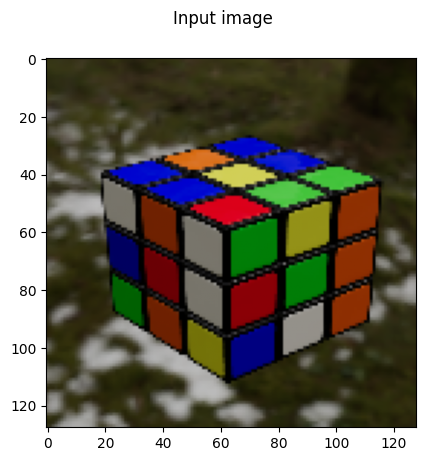

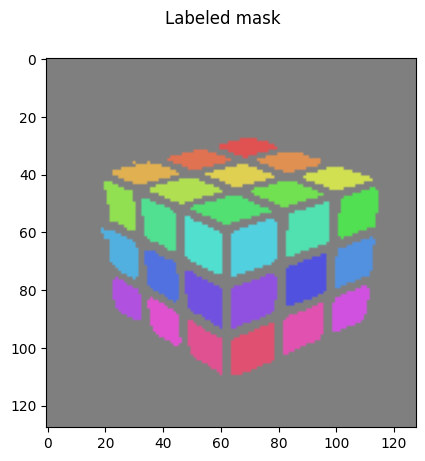

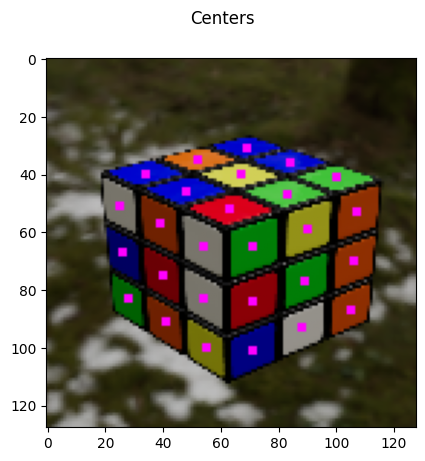

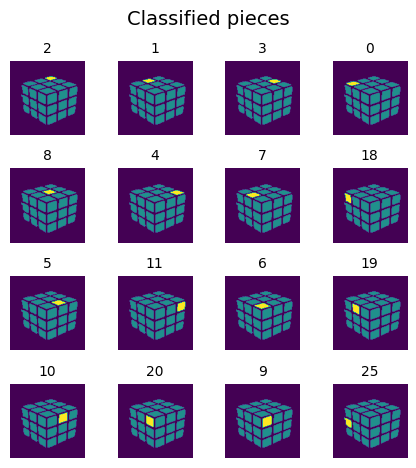

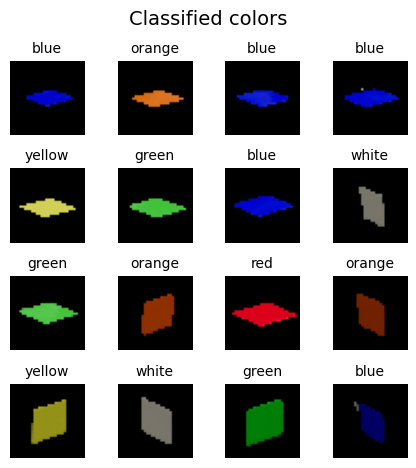

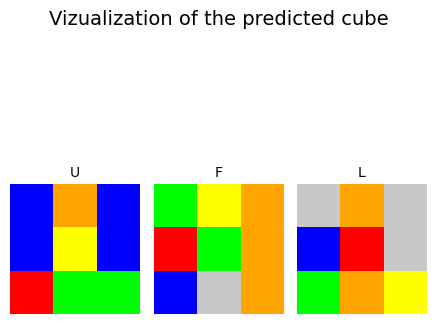

In [57]:
idx = 1

rubiks_imgs = segmentationModel.test_dataset["input"]
labeled_masks = create_labeled_masks(segmentationModel.model, rubiks_imgs)
centers_set = create_centers_set(labeled_masks)
centers_set, [rubiks_imgs, labeled_masks] = remove_bad_datapoints(
    centers_set, [rubiks_imgs, labeled_masks]
)

# Create seperate images for each label in each mask.
labeled_mask = labeled_masks[idx]
unique_labels = np.unique(labeled_mask)
unique_labels = unique_labels[1:] # Ignore background label.

piece_images = []
cropped_images = []
for i, l in enumerate(unique_labels):
  img = np.zeros((128, 128))
  img[np.where(labeled_mask)] = 0.5
  img[np.where(labeled_mask == l)] = 1
  piece_images.append(img)

  cropped = crop_color_area(rubiks_imgs[idx], labeled_mask, centers_set[idx][i])
  cropped_images.append(cropped)
  
piece_images = np.array(piece_images)
cropped_images = np.array(cropped_images)
piece_predictions = pieceClassifier.predict(piece_images-0.5)
color_predictions = colorClassifier.predict(cropped_images-0.5)


plot_images([rubiks_imgs[idx]+0.5], title="Input image")
plot_labeled_mask(labeled_masks[idx])
draw_centers(rubiks_imgs[idx], centers_set[idx])
plot_images_grid(piece_images[:16], 4, 4, sub_titles=piece_predictions[:16], title="Classified pieces")
plot_images_grid(cropped_images[:16], 4, 4, sub_titles=list(map(lambda x: color_names[x], color_predictions[:16])), title="Classified colors")
visualize_cube(piece_predictions, color_predictions)

Compare the input image at the top of the output above with the cube visualization at the bottom. The cube visualization shows the predicted class for each piece on the three sides of the cube visible to the camera. In many cases all pieces are correctly classified, in some cases there is one or a few pieces that are incorrectly classified.

The letters in the visualization corresponds to the sides Upp, Front and Left and can be seen in the image below.

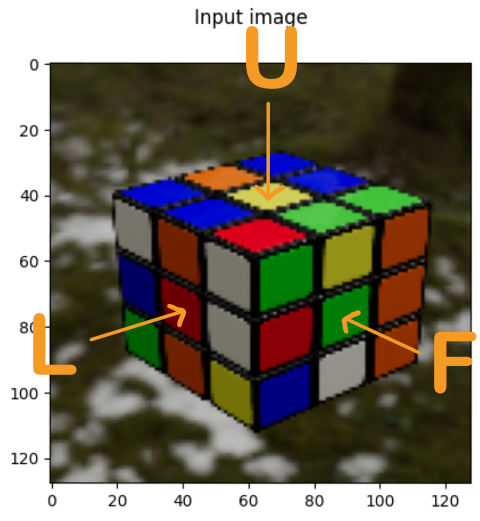

# Processing Data From Rubiks Generator
The code in this section does processing on the images that have been created in the Three.js Rubiks cube simulator to prepare them as dataset for the machine learning models above. Once the dataset is generated the code in this section doesn't need to be run anymore.

Since a segmentation model is needed in this section, one is loaded from a previous run from disk. However, it is the exact same model that is trained above.

To make it as realistic as possible I don't want to save entire arrays using pickle or similar, but rather everything should be stored as images or JSON. Therefore some small preprocessing will still be necesarry (normalizing, removing color channels, etc).

In [41]:
segmentationModel = keras.models.load_model(f"{rubiks_volume_path}/models/segmentation_model")

In [205]:
# color_output contains the correct color for each area.
def crop_color_input_images(color_input, color_ouput, labeled_masks, centers_set):
  color_classes = {
    (0, 255, 0): 0,
    (255, 255, 0): 1,
    (0, 0, 255): 2,
    (255, 255, 255): 3,
    (255, 0, 0): 4,
    (255, 210, 0): 5
  }

  size = 32

  cropped_images = []
  color_labels = []
  for idx in range(color_input.shape[0]):
    mask = labeled_masks[idx]
    classes = np.unique(mask)[1:] # ignore background
    output_image = color_ouput[idx]

    for area_index in range(27):
      img = color_input[idx]+0.5
      img[mask != classes[area_index]] = [0, 0, 0]
      center_y, center_x = centers_set[idx][area_index]
      cropped = img[center_y - size//2:center_y + size//2, center_x - size//2:center_x + size//2]
      cropped_images.append(cropped)

      color = output_image[center_y][center_x]
      color_labels.append(color_classes[tuple(color)])


  return np.array(cropped_images), np.array(color_labels)

In [ ]:
# Preprocess data for segmentation model and store to disk.

# No preprocessing required for the segmentation model.

In [ ]:
# Preprocess data for color classification model and store to disk.
def load_raw_data():
    normal_color_labels_dir = f"{rubiks_volume_path}/preprocessed/normal-color-labels"
    color_labels_dir = f"{rubiks_volume_path}/preprocessed/color-labels"
    normal_color_labels, color_labels = load_in_and_out_images(
        normal_color_labels_dir, color_labels_dir
    )
    normal_color_labels = normalize(normal_color_labels)

    return normal_color_labels, color_labels


input_data, output_data = load_raw_data()
labeled_masks = create_labeled_masks(segmentationModel, input_data)
centers_set = create_centers_set(labeled_masks)
centers_set, [input_data, output_data, labeled_masks] = remove_bad_datapoints(
    centers_set, [input_data, output_data, labeled_masks]
)

color_input, color_output = crop_color_input_images(input_data, output_data, labeled_masks, centers_set)
#plot_images_grid(color_input[16:32], 4, 4, list(map(lambda x: color_names[x], color_output[16:32])))

# Save the preprocessed data to disk.
input_dir = f"{rubiks_volume_path}/data-ready-for-training/color-input"

color_output_map = {}
for idx, img in enumerate(color_input):
  filename = f"{uuid.uuid4()}.png"
  color_output_map[filename] = int(color_output[idx])

  img = Image.fromarray((img * 255).astype(np.uint8))
  img.save(os.path.join(input_dir, filename))

with open(f"{rubiks_volume_path}/data-ready-for-training/color-output.json", "w") as f:
    json.dump(color_output_map, f)

32/32 [==============================] - 1s 39ms/step
Number of datapoints before removal: 1000
Number of datapoints after removal: 843


34/34 [==============================] - 1s 41ms/step


<Figure size 640x480 with 0 Axes>

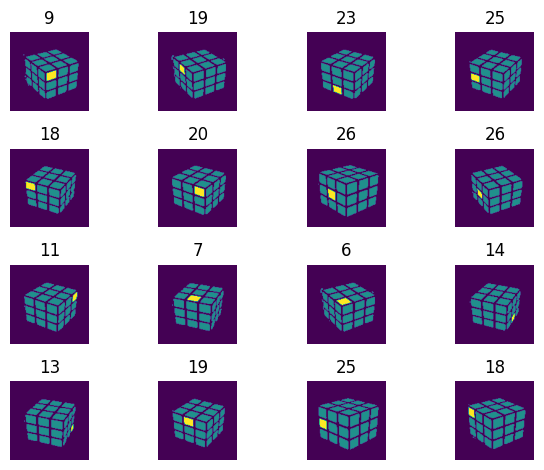

In [40]:
# Preprocess data for piece classification model and store to disk.
def generate_piece_bw_input(formated_masks, piece_highlighted):
  bw = np.zeros(formated_masks.shape)
  bw[np.where(formated_masks)] = 0.5

  mask = np.all(piece_highlighted == np.array([255, 0, 255]), axis=-1)
  bw[np.where(mask)[:3]] = 1

  return bw

def load_raw_data():
  piece_input_dir = f"{rubiks_volume_path}/preprocessed/piece-input"
  piece_output_dir = f"{rubiks_volume_path}/preprocessed/piece-output"

  piece_input, piece_output, file_order = load_in_and_out_images(piece_input_dir, piece_output_dir, True)
  piece_input = normalize(piece_input)

  with open(f"{rubiks_volume_path}/piece-classifications.json") as f:
    piece_class_map = json.load(f)

  piece_classes = np.array(list(map(lambda x: piece_class_map[x], file_order)))

  return piece_input, piece_output, piece_classes

piece_normal, piece_highlighted, piece_classes = load_raw_data()
formated_masks = create_masks(segmentationModel, piece_normal)
bw = generate_piece_bw_input(formated_masks, piece_highlighted)
plot_images_grid(bw[:16], 4, 4, piece_classes[:16])

# Save the preprocessed data to disk.
input_dir = f"{rubiks_volume_path}/data-ready-for-training/piece-input"

piece_classes_map = {}
for idx, img in enumerate(bw):
  filename = f"{uuid.uuid4()}.png"
  piece_classes_map[filename] = int(piece_classes[idx])

  img = Image.fromarray((img * 255).astype(np.uint8))
  img.save(os.path.join(input_dir, filename))

with open(f"{rubiks_volume_path}/data-ready-for-training/piece-output.json", "w") as f:
    json.dump(piece_classes_map, f)